> # Бајесова анализа на финансиски податоци од берзата на САД
> #### Јован Крајевски (199015)
> ##### јуни, 2022

## Собирање на податоци од берзата на САД

In [1]:
import yfinance
import time
import pandas as pd
from pathlib import Path

indexes = ["^GSPC"]

OVERWRITE_ANYWAY = False

DATA_LOCATION = Path(".") / "data"
DATA_LOCATION.mkdir(exist_ok=True, parents=True)

start_time = time.time()

if OVERWRITE_ANYWAY or not (DATA_LOCATION / "indexes.pkl").is_file():
    daily_smp = yfinance.download(" ".join(indexes),
                                  period="max",
                                  interval="1d")
    daily_smp.to_pickle(DATA_LOCATION / "indexes.pkl")

daily_smp = pd.read_pickle(DATA_LOCATION / "indexes.pkl")

end_time = time.time()
print(f"{end_time - start_time:.2f}s")

0.00s


In [2]:
daily_smp

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,16.660000,1260000
1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000
1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000
1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000
1950-01-09,17.080000,17.080000,17.080000,17.080000,17.080000,2520000
...,...,...,...,...,...,...
2022-05-23,3919.419922,3981.879883,3909.040039,3973.750000,3973.750000,3392770000
2022-05-24,3942.939941,3955.679932,3875.129883,3941.479980,3941.479980,3901640000
2022-05-25,3929.590088,3999.330078,3925.030029,3978.729980,3978.729980,4322190000


<IPython.core.display.Javascript object>


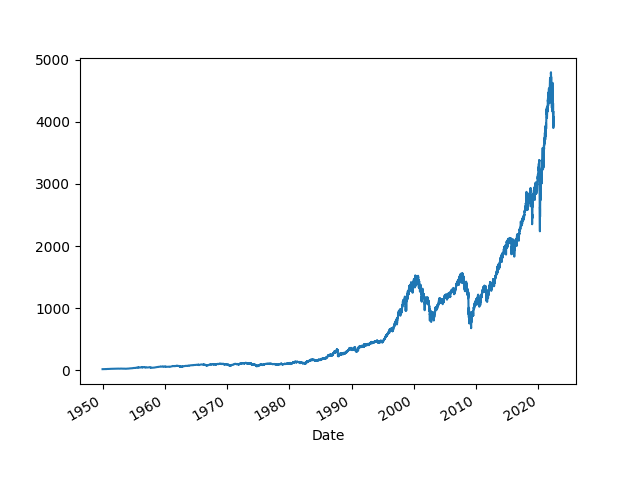

<AxesSubplot:xlabel='Date'>

In [3]:
%matplotlib notebook
daily_smp["Adj Close"].plot()

# Поделба на податоците на тренирачко и тестирачко множество

In [4]:
train_smp = daily_smp[daily_smp.index < "01-01-2007"].copy()
test_smp = daily_smp[daily_smp.index >= "01-01-2007"].copy()
len(train_smp), len(test_smp)

(14341, 3879)

# Трансформации на податоците

In [5]:
import numpy as np

def transform_close(df):
    df["close"] = df["Adj Close"]
    df["close_return"] = df["close"].pct_change(periods=1)
    df["close_diff"] = df["close"].diff(periods=1)
    df["close_log_return"] = np.log(df["close"]) - np.log(df["close"].shift(1))
    df.dropna(inplace=True)
    
transform_close(train_smp)
transform_close(test_smp)

<IPython.core.display.Javascript object>


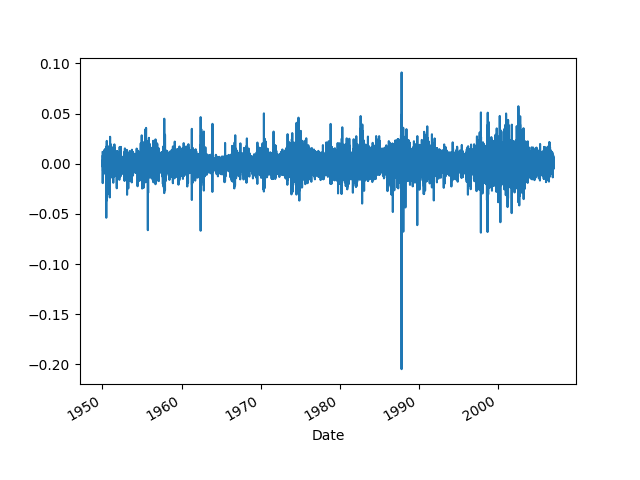

<AxesSubplot:xlabel='Date'>

In [6]:
train_smp["close_return"].plot()

<IPython.core.display.Javascript object>


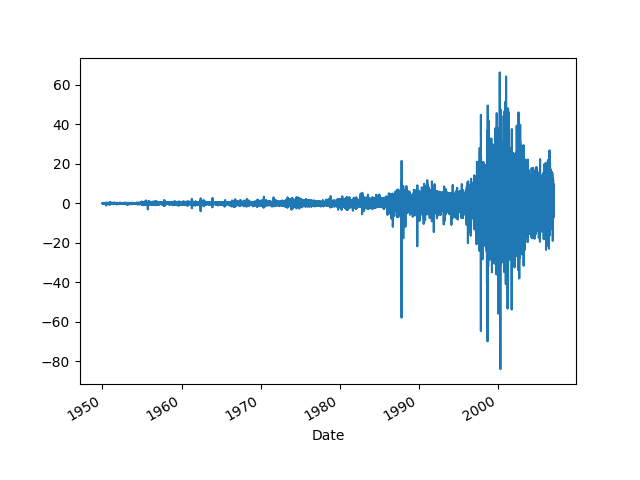

<AxesSubplot:xlabel='Date'>

In [7]:
train_smp["close_diff"].plot()

<IPython.core.display.Javascript object>


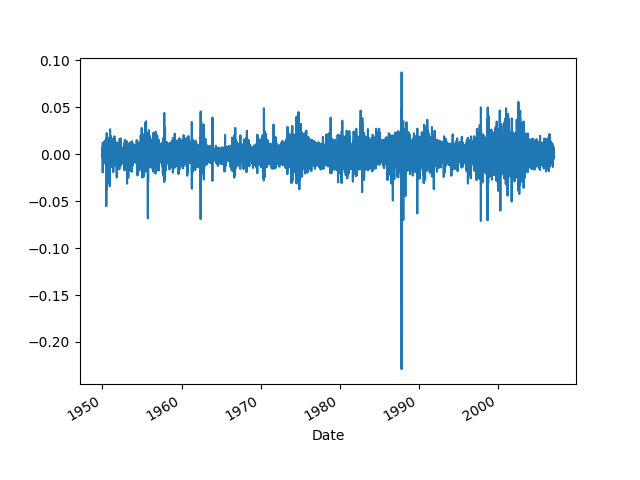

<AxesSubplot:xlabel='Date'>

In [8]:
train_smp["close_log_return"].plot()

# Стационарност

adf:  If Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis(HO) i.e., time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.
RESULT: stationary

kpss: If Test statistic < Critical Value and p-value < 0.05 – Fail to Reject Null Hypothesis(HO) i.e., time series does not have a unit root, meaning it is trend stationary.
RESULT: not stationary

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = {title: adf_test[idx] for idx, title in enumerate(['Test Statistic','p-value','#Lags Used'])}
    for key,value in adf_test[4].items():
        adf_output[f'Critical Value ({key})'] = value

    return adf_output
    
def kpss_test(timeseries):
    kpss_test = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = {title: kpss_test[idx] for idx, title in enumerate(['Test Statistic','p-value','#Lags Used'])}
    for key,value in kpss_test[3].items():
        kpss_output[f'Critical Value ({key})'] = value

    return kpss_output
    
def interpret_results(adf_output, kpss_output):
    reject_h0 = []
    for test_output in [adf_output, kpss_output]:
        is_test_stat_larger = True
        for key, value in test_output.items():
            if "Critical" not in key:
                continue

            is_test_stat_larger = is_test_stat_larger and (test_output["Test Statistic"] > value)

        reject_h0.append(not is_test_stat_larger and test_output["p-value"] < 0.05)
        
    if reject_h0[0] and not reject_h0[1]:
        print("stationary")
    elif not reject_h0[0] and reject_h0[1]:
        print("non-stationary")
    elif not reject_h0[0] and not reject_h0[1]:
        print("trend-stationary")
    else:
        print("diff-stationary")

for series in ["close", "close_return", "close_diff", "close_log_return"]:
    adf_output = adf_test(train_smp[series])
    kpss_output = kpss_test(train_smp[series])
    print(series)
    interpret_results(adf_output, kpss_output)

/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


close
trend-stationary


/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


close_return
stationary
close_diff
diff-stationary
close_log_return
stationary


/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Авто-корелираност

The Durbin Watson test has values between 0 and 4. Below is the table containing values and their interpretations:

- 2: No autocorrelation. Generally, we assume 1.5 to 2.5 as no correlation.
- [0, 2): positive autocorrelation. The more close it to 0, the more signs of positive autocorrelation.
- (2 -4]: negative autocorrelation. The more close it to 4, the more signs of negative autocorrelation.

In [10]:
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS

for series in ["close_return", "close_log_return"]:
    X =np.arange(len(train_smp[series]))
    Y = np.asarray(train_smp[series])
    X = sm.add_constant(X)

    # Fit the ordinary least square method.
    ols_res = OLS(Y,X).fit()
    # apply durbin watson statistic on the ols residual
    dw = durbin_watson(ols_res.resid)
    print(f"{series} durbin-watson test value: {dw}")

close_return durbin-watson test value: 1.844345013591561
close_log_return durbin-watson test value: 1.8448787792469894


# Распределба на log-return

<IPython.core.display.Javascript object>


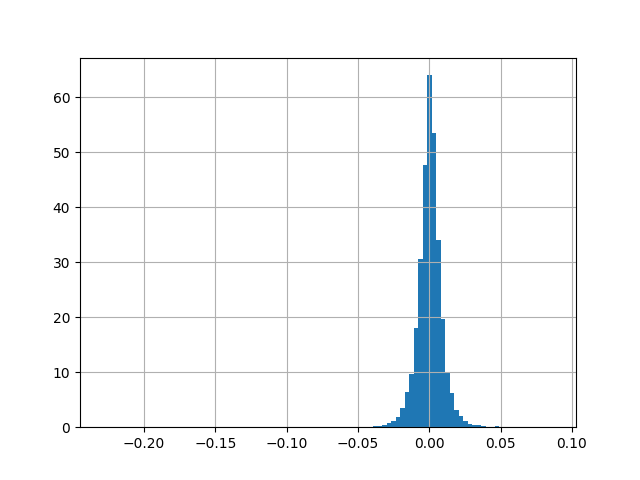

<AxesSubplot:>

In [11]:
train_smp["close_log_return"].hist(bins=100, density=True)

In [12]:
from scipy import stats


def get_distribution(df):
    cauchy_p_value = stats.kstest(df, "cauchy", stats.cauchy.fit(df))[1]
    gennorm_p_value = stats.kstest(df, "gennorm", stats.gennorm.fit(df))[1]
    p_values = list(
        zip([cauchy_p_value, gennorm_p_value], [0, 1]))

    return max(p_values)[1]

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>


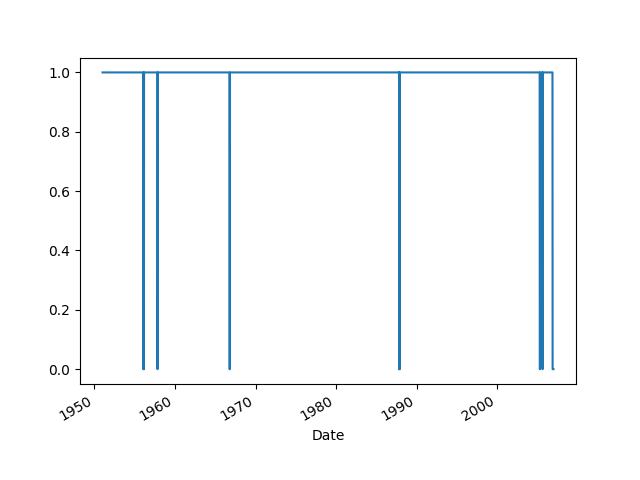

36.74s


In [13]:
from pandarallel import pandarallel
pandarallel.initialize()

start_time = time.time()
x = train_smp["close_log_return"].interpolate()
dists = x.rolling(250).parallel_apply(get_distribution)
dists.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

In [14]:
(dists == 1).mean(), (dists == 0).mean()

(0.9755230125523012, 0.007112970711297071)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>


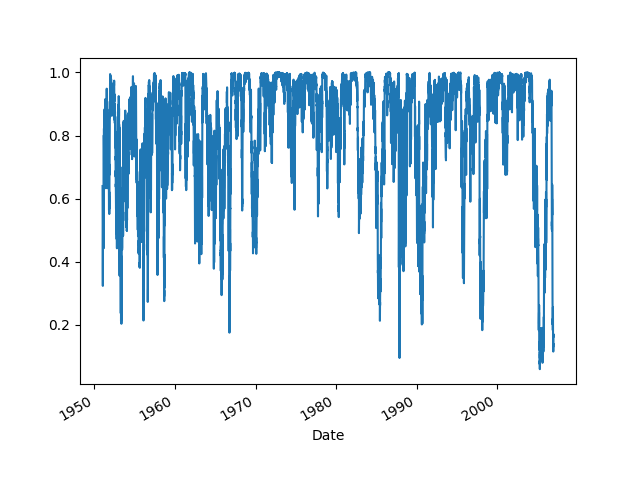

30.49s


In [15]:
def get_gennorm_p_values(df):
    return stats.kstest(df, "gennorm", stats.gennorm.fit(df))[1]

pandarallel.initialize()
start_time = time.time()
x = train_smp["close_log_return"].interpolate()
gennorm_p_values = x.rolling(250).parallel_apply(get_gennorm_p_values)
gennorm_p_values.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

In [16]:
gennorm_p_values.mean()

0.8211481553531417

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>


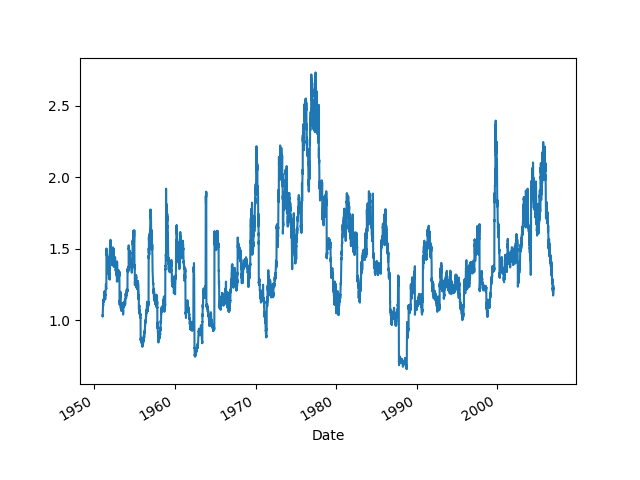

29.34s


In [17]:
def get_gennorm_betas(df):
    return stats.gennorm.fit(df)[0]

pandarallel.initialize()
start_time = time.time()
x = train_smp["close_log_return"].interpolate()
betas = x.rolling(250).parallel_apply(get_gennorm_betas)
betas.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

<IPython.core.display.Javascript object>


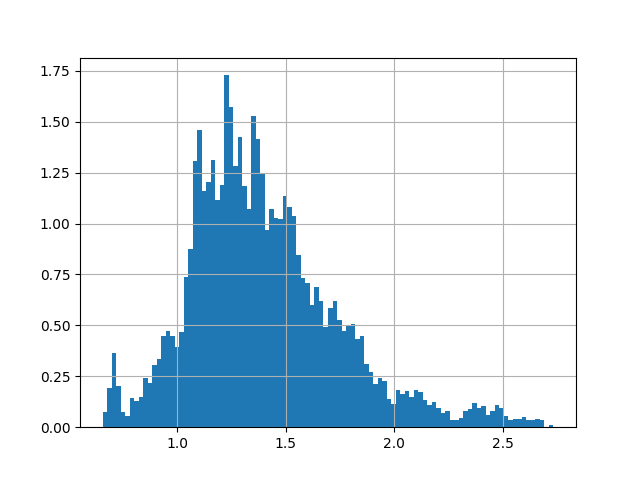

<AxesSubplot:>

In [18]:
betas.hist(density=True, bins=100)

# Прозорци (rolling windows)

In [19]:
def get_rolling_windows(df, L=250):
    return [df.iloc[x:x + L] for x in range(len(df) - L + 1)]

start_time = time.time()

train_data = get_rolling_windows(train_smp)
test_data = get_rolling_windows(test_smp)

end_time = time.time()
print(f"{end_time - start_time:.2f}s")

len(train_data), len(test_data)

0.53s


(14091, 3629)

In [20]:
train_data[0]

,Open,High,Low,Close,Adj Close,Volume,close,close_return,close_diff,close_log_return
Date,,,,,,,,,,
1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000,16.850000,0.011405,0.190001,0.011340
1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000,16.930000,0.004748,0.080000,0.004737
1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000,16.980000,0.002953,0.049999,0.002949
1950-01-09,17.080000,17.080000,17.080000,17.080000,17.080000,2520000,17.080000,0.005889,0.100000,0.005872
1950-01-10,17.030001,17.030001,17.030001,17.030001,17.030001,2160000,17.030001,-0.002927,-0.049999,-0.002932
...,...,...,...,...,...,...,...,...,...,...
1950-12-27,20.299999,20.299999,20.299999,20.299999,20.299999,2940000,20.299999,0.019076,0.379999,0.018897
1950-12-28,20.379999,20.379999,20.379999,20.379999,20.379999,3560000,20.379999,0.003941,0.080000,0.003933
1950-12-29,20.430000,20.430000,20.430000,20.430000,20.430000,3440000,20.430000,0.002453,0.050001,0.002450


# Бајесова анализа

In [73]:
import numpy as np
import pymc as pm
from scipy import stats as ss


def from_posterior(param, samples, testval, set_testval):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = ss.gaussian_kde(samples.data.flatten())(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    if set_testval:
        return pm.distributions.Interpolated(param, x, y, initval=testval)

    return pm.distributions.Interpolated(param, x, y)

In [30]:
def get_stats(sample):
    return [
        np.mean(sample),
        ss.tstd(sample),
        np.mean(sample > 0),
        ss.skew(sample),
        ss.kurtosis(sample),
    ] + [np.percentile(sample, p) for p in range(0, 101, 5)]


get_stats(np.random.randn(10000))

[0.004883925655756251,
 1.004922589984178,
 0.5024,
 -0.027754676380136196,
 -0.054862353886507176,
 -3.713913642417907,
 -1.65974710894061,
 -1.3001487989165839,
 -1.0509966312321397,
 -0.8467909673492783,
 -0.6712431560667017,
 -0.513795578961295,
 -0.3695877055513457,
 -0.24252094492127674,
 -0.11085277785254595,
 0.008120189859829756,
 0.1296050071449141,
 0.25524929177411776,
 0.39155627285855443,
 0.5319588009594091,
 0.6883155381607335,
 0.8574782238945458,
 1.0620420385516172,
 1.2930719563776223,
 1.6427872279230222,
 3.543847059046537]

## Бајесова анализа со нормален приор

In [23]:
import pickle

DATA_LOCATION = Path(".") / "models"
DATA_LOCATION.mkdir(exist_ok=True, parents=True)


def read_stats_and_model(model_name):
    if not (DATA_LOCATION / model_name).is_file():
        return [], None

    with open(DATA_LOCATION / model_name, "rb") as f:
        return pickle.load(f)


def write_stats_and_model(model_name, stats, model):
    with open(DATA_LOCATION / model_name, "wb") as f:
        pickle.dump((stats, model), f)

In [104]:
with open(DATA_LOCATION / "test.pkl", "wb") as f:
    pickle.dump(model, f)

AttributeError: Can't pickle local object 'interpolated_default_transform.<locals>.transform_params'

In [105]:
pm.__version__

'4.0.0'

In [57]:
def get_initial_normal_model(data, prior_mu_mean, prior_mu_sigma,
                             prior_std_sigma):
    mu_testval, std_testval = ss.norm.fit(data.get_value())
    model = pm.Model()
    with model:
        mu = pm.Normal("mu",
                       mu=prior_mu_mean,
                       sigma=prior_mu_sigma,
                       initval=mu_testval)
        std = pm.HalfNormal("std", sigma=prior_std_sigma, initval=std_testval)
        obs = pm.Normal("obs", mu=mu, sigma=std, observed=data)

    return model


def get_next_normal_model(data, trace, set_testval):
    mu_testval, std_testval = ss.norm.fit(data.get_value())
    model = pm.Model()
    with model:
        mu = from_posterior("mu", trace["posterior"]["mu"], mu_testval,
                            set_testval)
        std = from_posterior("std", trace["posterior"]["std"], std_testval,
                             set_testval)
        obs = pm.Normal("obs", mu=mu, sigma=std, observed=data)

    return model

In [25]:
start_time = time.time()

prior_mu_mean = np.array(
    [window["close_log_return"].mean() for window in train_data]).mean()
prior_mu_sigma = np.array(
    [window["close_log_return"].mean() for window in train_data]).std(ddof=1)
prior_std_sigma = np.array(
    [window["close_log_return"].std() for window in train_data]).std(ddof=1)

end_time = time.time()
print(f"{end_time - start_time:.2f}s")
print(prior_mu_mean, prior_mu_sigma, prior_std_sigma)

2.53s
0.000302779667213874 0.0005921371039989852 0.003211753846880127


In [35]:
import aesara

data_sample = aesara.shared(train_data[0]["close_log_return"].to_numpy())

model = get_initial_normal_model(data_sample, prior_mu_mean, prior_mu_sigma,
                                 prior_std_sigma)

with model:
    trace = pm.sample(draws=2000, chains=6, cores=6)
    posterior_obs = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [mu, std]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 4 seconds.


<IPython.core.display.Javascript object>


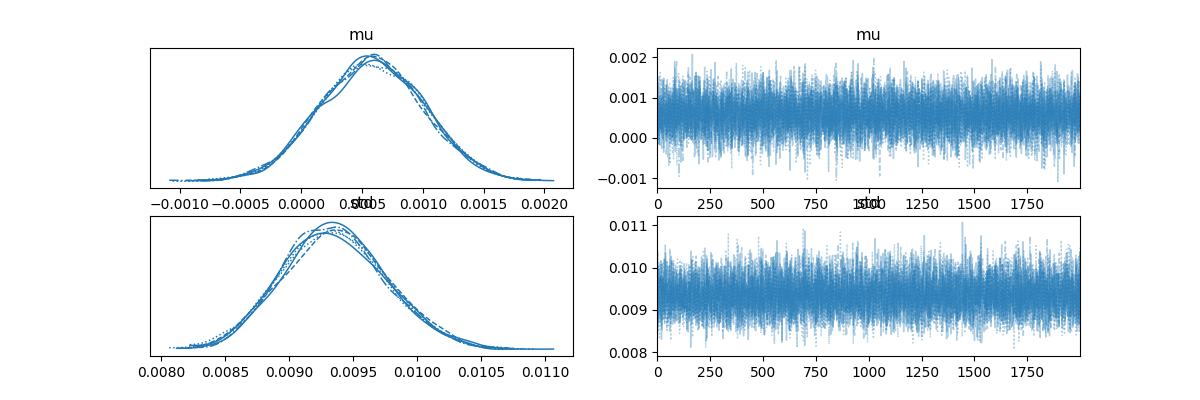

<IPython.core.display.Javascript object>


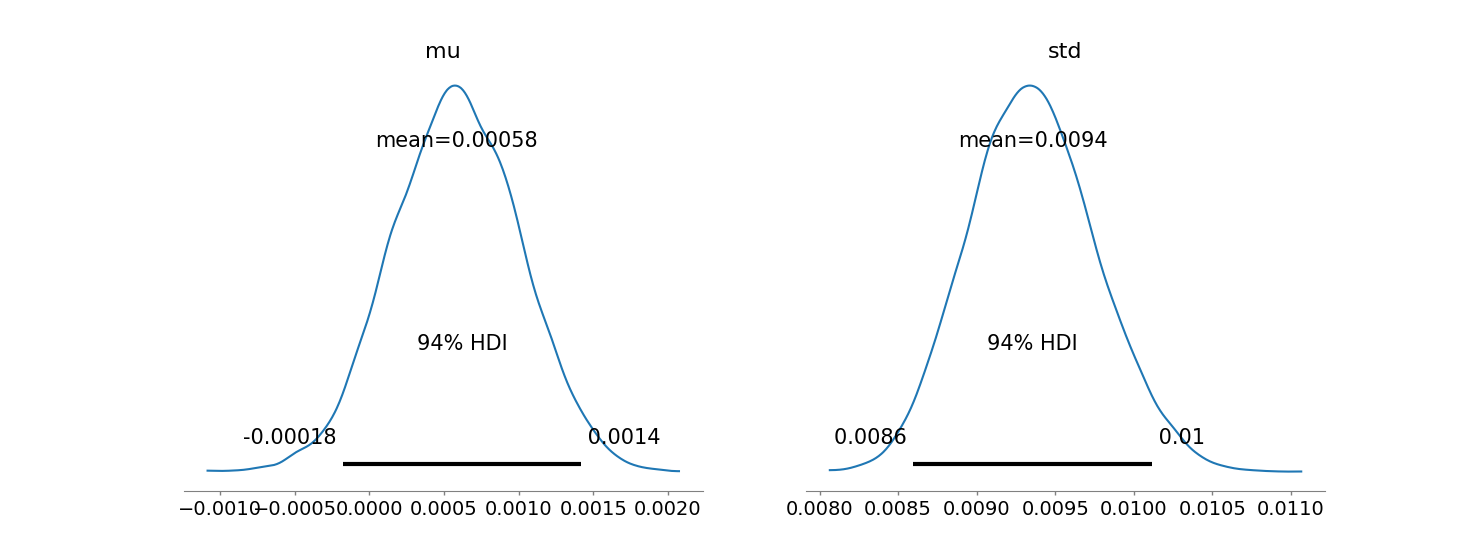

In [36]:
import arviz as az
with model:
    az.plot_trace(trace)
    az.plot_posterior(trace)

<IPython.core.display.Javascript object>


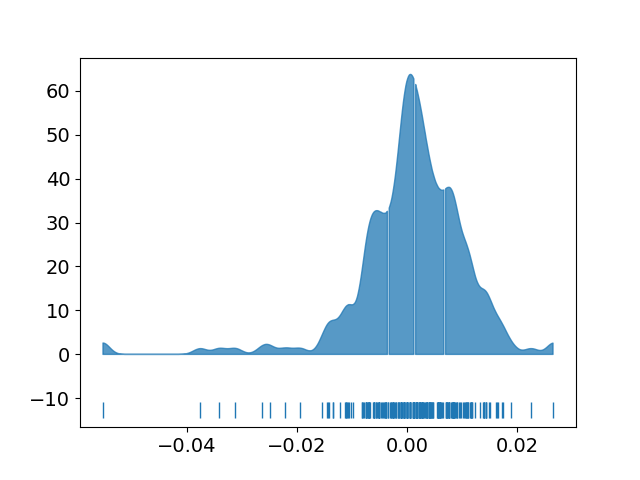

In [51]:
with model:
    az.plot_dist(posterior_obs["observed_data"]["obs"],
                 rug=True,
                 quantiles=[.25, .5, .75])

In [74]:
data_sample = aesara.shared(train_data[1]["close_log_return"].to_numpy())

model = get_next_normal_model(data_sample, trace, True)

with model:
    trace = pm.sample(draws=2000, chains=6, cores=6)
    posterior_obs = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [mu, std]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 4 seconds.


<IPython.core.display.Javascript object>


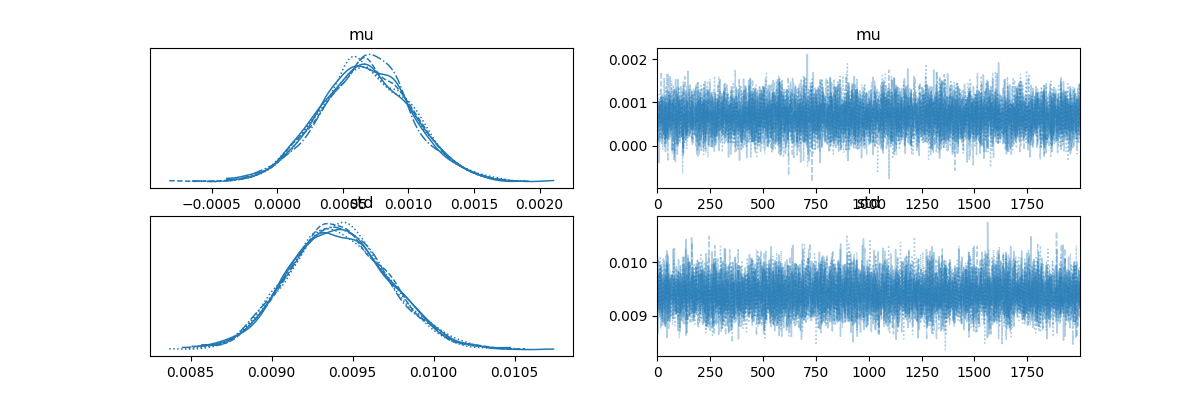

<IPython.core.display.Javascript object>


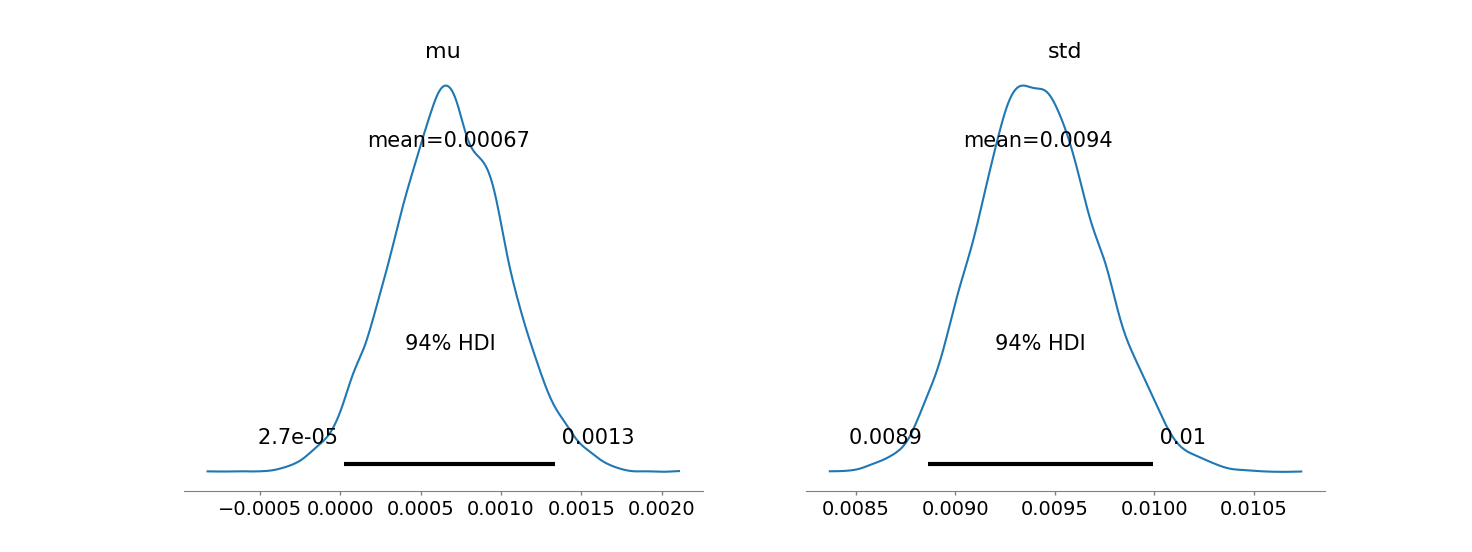

In [75]:
with model:
    az.plot_trace(trace)
    az.plot_posterior(trace)

<IPython.core.display.Javascript object>


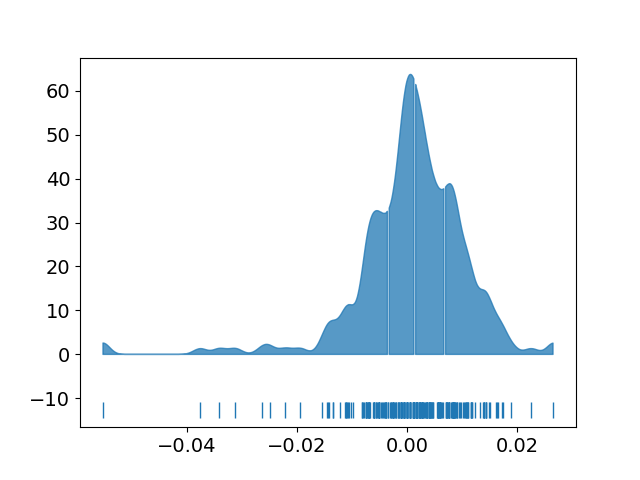

In [76]:
with model:
    az.plot_dist(posterior_obs["observed_data"]["obs"],
                 rug=True,
                 quantiles=[.25, .5, .75])

In [99]:
import aesara

test = 0


def train_model(
        model_name,
        get_initial_model_func,
        initial_model_args,
        get_next_model_func,
        update_priors_on=60,  # update priors after 60 windows
        save_every=10,  # save model after 10 windows
        verbosity=1000,  # print info about progress after 10 windows
        draws=2000,
        chains=6,
        cores=6):
    success = False
    global test
    while not success:
        #         try:
        data_sample = aesara.shared(
            train_data[0]["close_log_return"].to_numpy())

        stats, model = read_stats_and_model(model_name)
        trace = None

        if not model:
            model = get_initial_model_func(data_sample, *initial_model_args)

        if len(stats) and len(stats) % update_priors_on == 0:
            # recalculate last window so that we have trace
            stats = stats[:-1]

        for idx, window in enumerate(train_data):
            if idx % verbosity == 0:
                print(
                    f"Window {idx + 1}/{len(train_data)} ({(idx + 1)/len(train_data)*100:.2f}%)..."
                )

            if idx < len(stats):
                continue  # window is already processed

            data_sample.set_value(window["close_log_return"].to_numpy())

            if idx % update_priors_on == 0 and idx > 0:
                next_model = get_next_model_func(data_sample, trace, True)
                if not next_model.check_test_point().isna().any():
                    model = next_model
                else:
                    with open("logs.txt", "a") as f:
                        f.write(f"{model_name}_{idx} - Failed set_testval")

                    model = get_next_model_func(data_sample, trace, False)

            with model:
                trace = pm.sample(draws=draws, chains=chains, cores=cores)
                posterior_obs = pm.sample_posterior_predictive(trace)

            test = posterior_obs
            stats.append(
                get_stats(
                    posterior_obs["observed_data"]["obs"].data.flatten()))
            test=model
            if idx % save_every == 0:
                write_stats_and_model(model_name, stats, model)

        write_stats_and_model(model_name, stats, model)
        success = True


#         except Exception as e:
#             with open("logs.txt", "a") as f:
#                 f.write(str(e))
#                 f.write("\n")

In [100]:
train_model("fixed_normal.pkl", get_initial_normal_model,
            [prior_mu_mean, prior_mu_sigma, prior_std_sigma],
            get_next_normal_model)

Window 1/14091 (0.01%)...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [mu, std]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 4 seconds.


AttributeError: Can't pickle local object '_make_nice_attr_error.<locals>.fn'

In [101]:
test

# Бајесова анализа со двојно-експоненцијален (Лапласов) приор

In [11]:
def get_initial_laplace_model(data, prior_mu_mean, prior_mu_sigma,
                              prior_std_sigma):
    mu_testval, b_testval = ss.laplace.fit(data.get_value())
    model = pm.Model()
    with model:
        mu = pm.Normal("mu",
                       mu=prior_mu_mean,
                       sigma=prior_mu_sigma,
                       testval=mu_testval)
        b = pm.HalfNormal("b", sigma=prior_std_sigma, testval=b_testval)
        obs = pm.Laplace("obs", mu=mu, b=b, observed=data)

    return model


def get_next_laplace_model(data, trace, set_testval):
    mu_testval, b_testval = ss.laplace.fit(data.get_value())
    model = pm.Model()
    with model:
        mu = from_posterior("mu", trace["mu"], mu_testval, set_testval)
        b = from_posterior("b", trace["b"], b_testval, set_testval)
        obs = pm.Laplace("obs", mu=mu, b=b, observed=data)

    return model


train_model("fixed_laplace.pkl", get_initial_laplace_model,
            [prior_mu_mean, prior_mu_sigma, prior_std_sigma],
            get_next_laplace_model)

Window 1/14091 (0.01%)...
Window 1001/14091 (7.10%)...
Window 2001/14091 (14.20%)...
Window 3001/14091 (21.30%)...
Window 4001/14091 (28.39%)...
Window 5001/14091 (35.49%)...
Window 6001/14091 (42.59%)...
Window 7001/14091 (49.68%)...
Window 8001/14091 (56.78%)...
Window 9001/14091 (63.88%)...
Window 10001/14091 (70.97%)...
Window 11001/14091 (78.07%)...
Window 12001/14091 (85.17%)...
Window 13001/14091 (92.26%)...
Window 14001/14091 (99.36%)...


# Тестирање на моделите

In [12]:
def test_model(
        train_model_name,
        get_next_model_func,
        update_priors_on=60,  # update priors after 60 windows
        save_every=10,  # save model after 10 windows
        verbosity=1000,  # print info about progress after 10 windows
        draws=2000,
        chains=6,
        cores=6):
    success = False
    while not success:
        try:
            [file_name, file_extenstion] = train_model_name.split('.')
            test_model_name = f"{file_name}_test.{file_extenstion}"
            data_sample = theano.shared(test_data[0]["close_log_return"].to_numpy())

            train_stats, train_model = read_stats_and_model(train_model_name)
            test_stats, test_model = read_stats_and_model(test_model_name)
            trace = None

            if not test_model:
                test_model = train_model

            if len(test_stats) and len(test_stats) % update_priors_on == 0:
                # recalculate last window so that we have trace
                test_stats = test_stats[:-1]

            for idx, window in enumerate(test_data):
                if idx % verbosity == 0:
                    print(
                        f"Window {idx + 1}/{len(test_data)} ({(idx + 1)/len(test_data)*100:.2f}%)..."
                    )

                if idx < len(test_stats):
                    continue  # window is already processed

                data_sample.set_value(window["close_log_return"].to_numpy())

                if idx % update_priors_on == 0 and idx > 0:
                    next_model = get_next_model_func(data_sample, trace, True)
                    if not next_model.check_test_point().isna().any():
                        test_model = next_model
                    else:
                        with open("logs.txt", "a") as f:
                            f.write(
                                f"{test_model_name}_{idx} - Failed set_testval"
                            )

                        test_model = get_next_model_func(
                            data_sample, trace, False)

                with test_model:
                    trace = pm.sample(draws=draws,
                                      step=[pm.Metropolis()],
                                      chains=chains,
                                      cores=cores,
                                      progressbar=False)
                    posterior_obs = pm.fast_sample_posterior_predictive(trace)

                test_stats.append(get_stats(posterior_obs["obs"].flatten()))
                if idx % save_every == 0:
                    write_stats_and_model(test_model_name, test_stats,
                                          test_model)

            write_stats_and_model(test_model_name, test_stats, test_model)
            success = True
        except Exception as e:
            with open("logs.txt", "a") as f:
                f.write(str(e))

In [15]:
test_model("fixed_normal.pkl", get_next_normal_model)
test_model("fixed_laplace.pkl", get_next_laplace_model)

Window 1/3629 (0.03%)...
Window 1001/3629 (27.58%)...
Window 2001/3629 (55.14%)...
Window 3001/3629 (82.69%)...
Window 1/3629 (0.03%)...
Window 1001/3629 (27.58%)...
Window 2001/3629 (55.14%)...
Window 3001/3629 (82.69%)...


In [ ]:
from pymc3 import Continuous

class GenNormal(Continuous):
    rv_op = normal

    @classmethod
    def dist(cls, mu=0, sigma=None, tau=None, no_assert=False, **kwargs):
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        sigma = at.as_tensor_variable(sigma)

        # tau = at.as_tensor_variable(tau)
        # mean = median = mode = mu = at.as_tensor_variable(floatX(mu))
        # variance = 1.0 / self.tau

        if not no_assert:
            assert_negative_support(sigma, "sigma", "Normal")

        return super().dist([mu, sigma], **kwargs)

    def moment(rv, size, mu, sigma):
        mu, _ = at.broadcast_arrays(mu, sigma)
        if not rv_size_is_none(size):
            mu = at.full(size, mu)
        return mu

    def logcdf(value, mu, sigma):
        """
        Compute the log of the cumulative distribution function for Normal distribution
        at the specified value.
        Parameters
        ----------
        value : tensor_like of float
            Value(s) for which log CDF is calculated. If the log CDF for multiple
            values are desired the values must be provided in a numpy array or Aesara tensor.
        Returns
        -------
        TensorVariable
        """
        return check_parameters(
            normal_lcdf(mu, sigma, value),
            0 < sigma,
            msg="sigma > 0",
        )

In [109]:
a = 0
import scipy.special as sc
from functools import partial

def gennorm_logp(x, beta, loc, scale):
    global a
    logp = pm.math.log(beta/(2*scale)) - theano.tensor.gammaln(1.0/beta) - (pm.math.abs_(x - loc)/scale)**beta
    print(logp)
    a = logp
    return logp

def gennorm_ppf(x, beta, loc, scale):
    c = pm.math.sgn(x - 0.5)
    # evaluating (1. + c) first prevents numerical cancellation
    return c * (scale ** beta) * theano.tensor.gammainccinv(1.0/beta, (1.0 + c) - 2.0*c*x)**(1.0/beta) + loc

def gennorm_ppf_scalar(x, beta, loc, scale):
    c = np.sign(x - 0.5)
    # evaluating (1. + c) first prevents numerical cancellation
    return c * (scale ** beta) * sc.gammainccinv(1.0/beta, (1.0 + c) - 2.0*c*x)**(1.0/beta) + loc


def get_initial_gennorm_model(data, prior_mu_mean, prior_mu_sigma,
                              prior_std_sigma):
    beta_testval, mu_testval, std_testval = ss.gennorm.fit(data.get_value())
    model = pm.Model()
    with model:
        mu = pm.Normal("mu",
                       mu=prior_mu_mean,
                       sigma=prior_mu_sigma,
                       testval=mu_testval)
        scale = pm.HalfNormal("b", sigma=prior_std_sigma, testval=std_testval)
        logp = partial(gennorm_logp_custom, beta=1, loc=mu, scale=scale)
#         obs = pm.DensityDist("obs", logp, 
#                              observed={"value": data.get_value(), "beta": 1, 
#                                        "loc": mu, "scale": scale})
        obs = pm.DensityDist("obs", logp, 
                             observed=data)

    return model


def get_next_gennorm_model(data, trace, set_testval):
    beta_testval, mu_testval, std_testval = ss.gennorm.fit(data.get_value())
    model = pm.Model()
    with model:
#         mu = from_posterior("mu", trace["mu"], mu_testval, set_testval)
#         b = from_posterior("b", trace["b"], b_testval, set_testval)
        obs = pm.DensityDist("obs", ss.gennorm.logpdf, 
                             observed={"value": data.get_value(), "beta": 1, 
                                       "loc": 0, "scale": 1})

    return model


data_sample = theano.shared(train_data[0]["close_log_return"].to_numpy())

model = get_initial_gennorm_model(data_sample, prior_mu_mean, prior_mu_sigma,
                                 prior_std_sigma)

with model:
    trace = pm.sample(draws=2000, step=[pm.Metropolis()], chains=6, cores=6)
    posterior_obs = pm.fast_sample_posterior_predictive(trace)

Elemwise{sub,no_inplace}.0
Elemwise{sub,no_inplace}.0
Elemwise{sub,no_inplace}.0


/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [b]
>Metropolis: [mu]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 2 seconds.
The number of effective samples is smaller than 25% for some parameters.


ValueError: Distribution was not passed any random method. Define a custom random method and pass it as kwarg random

In [104]:
old = ss.gennorm.logpdf(train_data[0]["close_log_return"], 1.2, loc=0.5, scale=1.3)
new = gennorm_logp_custom(train_data[0]["close_log_return"], 1.2, loc=0.5, scale=1.3)
(old - new).sum()

Elemwise{sub,no_inplace}.0


Sum{acc_dtype=float64}.0

In [121]:
old = ss.gennorm.ppf(0.95, 2.2, loc=15.5, scale=40.3)
new = gennorm_ppf_scalar(0.95, 2.2, loc=15.5, scale=40.3)
(old - new)

-3724.9529227118787

In [118]:
old

730.6559079746844

In [119]:
new

2386.2068182991125